## **Analytic Antipodal Grasps**

In [1]:
import matplotlib.pyplot as plt
import mpld3
import numpy as np
from pydrake.all import (
    Evaluate,
    Jacobian,
    MathematicalProgram,
    Solve,
    Variable,
    atan,
    cos,
    eq,
    sin,
)

from manipulation import running_as_notebook

if running_as_notebook:
    mpld3.enable_notebook()

## Introduction to Symbolic Differentiation 

For this assignment, you will need [symbolic differentiation](https://en.wikipedia.org/wiki/Computer_algebra), supported by Drake's symbolic library. We will demonstrate how to use it with a simple function: 
$$T=\cos^2(x) + y^5$$

and it's Jacobian (first-order derivative), 
$$J = \begin{pmatrix} \frac{\partial T}{\partial x} & \frac{\partial T}{\partial y} \end{pmatrix}=\begin{pmatrix} -2\cos(x)\sin(x) & 5y^4 \end{pmatrix}$$

as well as the Hessian (second-order derivative), 
$$H = \begin{pmatrix} \frac{\partial^2 T}{\partial x^2} & \frac{\partial^2 T}{\partial x \partial y} \\ \frac{\partial^2 T}{\partial y \partial x} & \frac{\partial^2 T}{\partial y^2} \end{pmatrix}=\begin{pmatrix} 2 \sin^2(x) - 2\cos^2(x) & 0 \\ 0 & 20y^3 \end{pmatrix}$$

Below are some snippets of how to define symbolic variables, differentiate expressions, and evaluate them using numerical values. 

In [2]:
# 1. Symbolic variables are defined
x = Variable("x")
y = Variable("y")

# 2. Expressions can be written by composing operations on Variables.
T = cos(x) ** 2.0 + y**5.0
print(T)

# 3. Use Evaluate to query the numerical value of the expression given the variable values.
# Use function for multi-dimensional quantities
print(Evaluate(np.array([T]), {x: 3.0, y: 5.0}))
# Use method for scalar quantities
print(T.Evaluate({x: 3.0, y: 5.0}))

# 4. Differentiate a quantity using Jacobian, or Differentiate.
J = np.array([T.Differentiate(x), T.Differentiate(y)])
print(J)
# Use method for scalar quantities
J = T.Jacobian([x, y])
print(J)
print(Evaluate(J, {x: 3.0, y: 5.0}))

# Use function for taking Jacobian of multi-dimensional quantities.
H = Jacobian(J, [x, y])
print(H)
print(Evaluate(H, {x: 3.0, y: 5.0}))

(pow(y, 5) + pow(cos(x), 2))
[[3125.98008514]]
3125.980085143325
[<Expression "(-2 * sin(x) * cos(x))"> <Expression "(5 * pow(y, 4))">]
[<Expression "(-2 * sin(x) * cos(x))"> <Expression "(5 * pow(y, 4))">]
[[2.79415498e-01]
 [3.12500000e+03]]
[[<Expression "(2 * pow(sin(x), 2) - 2 * pow(cos(x), 2))">
  <Expression "0">]
 [<Expression "0"> <Expression "(20 * pow(y, 3))">]]
[[-1.92034057e+00  0.00000000e+00]
 [ 0.00000000e+00  2.50000000e+03]]


Are the symbolic values of the Jacobian and Hessian what you expect? 

## The Cycloidal Gear

Now we enter the main part of the problem. 

After graduating from MIT, you decide to work at a company producing cutting-edge [hypercycloidal gears](https://youtu.be/MBWkibie_5I?t=74). You are in charge of designing a robotic pick-and-place system for these parts. In order to reliably grasp the gears, you decide to use your knowledge of antipodal points. 

The mechanical design department gave you a pretty ugly parametric equation for what the shape looks like, which we won't even bother writing in latex! Instead, we provided it via the function `shape`. 

Given a angle in polar coordinates (parameter $t$), it returns $p(t)=[x(t),y(t)]$, a position in 2D.  

The below cell implements the function and shows you what the gear part looks like. 

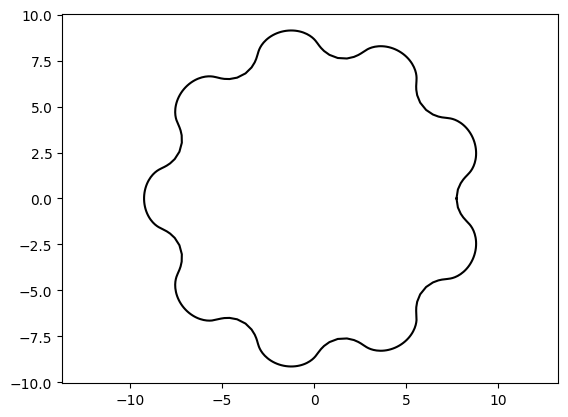

In [3]:
def shape(t):
    x = (
        (10 * cos(t))
        - (1.5 * cos(t + atan(sin(-9 * t) / ((4 / 3) - cos(-9 * t)))))
        - (0.75 * cos(10 * t))
    )
    y = (
        (-10 * sin(t))
        + (1.5 * sin(t + atan(sin(-9 * t) / ((4 / 3) - cos(-9 * t)))))
        + (0.75 * sin(10 * t))
    )
    return np.array([x, y])


def plot_gear():
    theta = np.linspace(0, 2 * np.pi, 500)
    gear_shape = []
    for i in range(500):
        gear_shape.append(Evaluate(shape(theta[i])).squeeze())
    gear_shape = np.array(gear_shape)
    plt.axis("equal")
    plt.plot(gear_shape[:, 0], gear_shape[:, 1], "k-")


plot_gear()

## Grasp Energy Function

How can we analytically find a pair of antipodal points given the parametric equation of a shape? We make the following claim: 

**Claim**: Let $p(t_1)$ and $p(t_2)$ be a pair of antipodal points given in parametric space. Then $t_1$ and $t_2$ are critical points of the following energy function:
$$E=\frac{1}{2}\kappa\|p(t_1)-p(t_2)\|^2$$

that is, they satisfy $\frac{\partial E}{\partial \mathbf{t}}=[0, 0]$ where $\mathbf{t}=[t_1,t_2]$. 

For the subsequent problems, you may assume $\kappa=2$. 

**Problem 5.1.a** [2pts]: Prove the claim. \\
**Problem 5.1.b** [2pts]: Prove that the converse may not necessarily hold. 

HINT: The derivative of $p(t)$ respect to $t$ gives the tangent 'velocity' vector: $v(t)=p'(t)$

Write down your answer in a paper / pdf file, and submit to the Gradescope written submission section! 

## Implementation

**Problem 5.1.c** [4pts]
Using this knowledge, we will write a Mathematical Program to find the antipodal points. Since we are looking for $t_1$ and $t_2$ such that the Jacobians is a zero vector, we are solving a root finding problem. Problems of this nature can still be transcribed as an instance of a Mathematical program;  it simply doesn't have a cost. 

We will write down our problem as follows: 

$$\begin{aligned} \text{find} \quad & \mathbf{t}  \\ \text{s.t.} \quad &  \frac{\partial E}{\partial \mathbf{t}}(\mathbf{t}) = \mathbf{0} \\ \quad & 0 \leq \mathbf{t} \leq 2\pi - \varepsilon  \\ \quad & t_1 - t_2 \geq \varepsilon \end{aligned}$$

The first constraint makes sure that they are critical points of the energy function, while the last two makes sure the points are not overlapping. You will write the following outer loop to check for the validity of solutions.

1. Pick a random guess for $\mathbf{t}$ using [SetInitialGuess](https://drake.mit.edu/doxygen_cxx/classdrake_1_1solvers_1_1_mathematical_program.html#ae48cb6d2263ccf09e38932dcd27f769f) by uniform sampling over $[0, 2\pi - \varepsilon]$ (use `np.random.rand(2)`). 
2. Using `MathematicalProgram`, solve the above problem. Remember there is no cost in this problem, so we simply only add the constraints. 
3. If the solution is not valid (i.e. problem doesn't return success), repeat 1-2 with random guesses until a valid solution is found. 
4. If a valid solution $\mathbf{t}^*$ is found, return the Eigenvalues of the Hessian of $E$ at $\mathbf{t}^*$. (Use `np.linalg.eigvals`)

In [12]:
def find_antipodal_pts(shape):
    """
    Finds antipodal points given the parametric function that describes the shape of the object.
    Args:
      - shape: function from parametric space t to position R2.
    Returns:
      - result: 2-dim np array that contains antipodal grasp locations parametrized by [t1, t2]
      - H_eig: 2-dim np array that contains eigenvalues of the Hessian.
    """

    eps = 1e-3  # do not modify, but use it for epsilon variable above.

    ## Fill your code here

    t1 = Variable("t1")
    t2 = Variable("t2")

    # relate t to the shape function
    shape_t = shape(t1)

    p = MathematicalProgram()

    p.SetInitialGuessForAllVariables(t1, np.random.uniform(0,2*np.pi-eps,2))
    p.AddConstraint(0 <= t)
    p.AddConstraint(t <= 2 * np.pi - eps)
    p.AddConstraint(eps <= t[1] - t[0])
    # add derivative constraints
    J = Jacobian(shape_t, t)
    H = Jacobian(J, t)
    p.AddConstraint(eq(J, 0))

    eig = np.eigh(H)

    result = np.array([shape_t[0], shape_t[1]])  # modify here
    H_eig = np.array([eig[0], eig[1]])  # modify here

    return result, H_eig

You can run the cell below to check the correctnes of your implementation. As the constraint is nonlinear, it might take some time to compute. (Typically, the solve time will still be less than 2~3 seconds).

TypeError: SetInitialGuessForAllVariables(): incompatible function arguments. The following argument types are supported:
    1. (self: pydrake.solvers.MathematicalProgram, arg0: numpy.ndarray[numpy.float64[m, 1]]) -> None

Invoked with: <pydrake.solvers.MathematicalProgram object at 0x13a52c9b0>, Variable('t1', Continuous), array([1.15755749, 5.92926653])

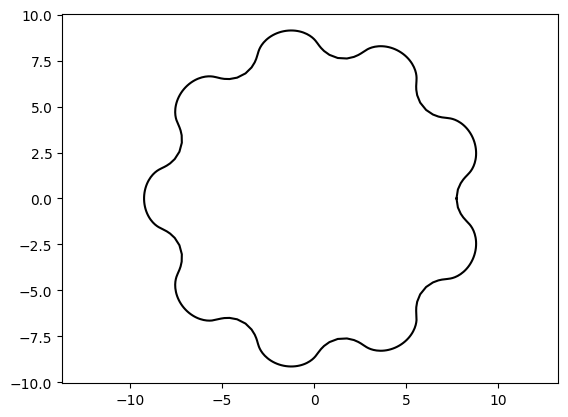

In [13]:
def get_antipodal_pts_on_shape(pts, shape):
    antipodal_pts = []
    for i in range(2):
        val = Evaluate(shape(pts[i])).squeeze()
        antipodal_pts.append(val)
    antipodal_pts = np.array(antipodal_pts)
    return antipodal_pts


def plot_antipodal_pts(pts, shape):
    antipodal_pts = get_antipodal_pts_on_shape(pts, shape)
    plt.scatter(antipodal_pts[:, 0], antipodal_pts[:, 1], color="red")


plot_gear()
result, H_eig = find_antipodal_pts(shape)
plot_antipodal_pts(result, shape)
print(H_eig)

## Hessian Analysis

Why did we implement the Hessian? You may remember that if the Hessian is used for the second-derivative test. For a function $f(x)$ with a critical point $x^*$, this critical point is:
- A local minima if the Hessian is positive-definite (i.e. all positive eigenvalues)
- A local maxima if the Hessian is negative-definite (i.e. all negative eigenvalues)
- A saddle point if the Hessian has mixed positive / negative eigenvalues. 

**Problem 5.1.d** [2pts] Describe what grasps the local minima, maxima, and saddle points correspond to in terms of the geometry of the object. In a very simple sentence, explain why you might prefer one configuration over another. 

HINT: The cell below will visualize each of the cases.

In [ ]:
if running_as_notebook:
    plt.subplot(1, 3, 1)
    plot_gear()
    plt.title("Local Minima")
    np.random.seed(45)
    while True:
        result, H_eig = find_antipodal_pts(shape)
        if (H_eig > 0).all():
            break
    plot_antipodal_pts(result, shape)

    plt.subplot(1, 3, 2)
    plot_gear()
    plt.title("Local Maxima")
    np.random.seed(4)
    while True:
        result, H_eig = find_antipodal_pts(shape)
        if (H_eig < 0).all():
            break
    plot_antipodal_pts(result, shape)

    plt.subplot(1, 3, 3)
    plot_gear()
    plt.title("Saddle Point")
    np.random.seed(13)
    while True:
        result, H_eig = find_antipodal_pts(shape)
        if (H_eig[0] > 0) and (H_eig[1] < 0):
            break
    plot_antipodal_pts(result, shape)

## How will this notebook be Graded?

If you are enrolled in the class, this notebook will be graded using [Gradescope](www.gradescope.com). You should have gotten the enrollement code on our announcement in Piazza. 

For submission of this assignment, you must do two things. 
- Download and submit the notebook `analytic_antipodal_grasps.ipynb` to Gradescope's notebook submission section, along with your notebook for the other problems.
- Write down your answers to 5.1.a, 5.1.b, and 5.1.d to a separately pdf file and submit it to Gradescope's written submission section. 

We will evaluate the local functions in the notebook to see if the function behaves as we have expected. For this exercise, the rubric is as follows:
- [2 pts] 5.1.a is answered correctly.
- [2 pts] 5.1.b is answered correctly. 
- [4 pts] `find_antipodal_points` must be implemented correctly.
- [2 pts] 5.1.d is answered correctly.

In [ ]:
from manipulation.exercises.clutter.test_analytic_grasp import TestAnalyticGrasp
from manipulation.exercises.grader import Grader

Grader.grade_output([TestAnalyticGrasp], [locals()], "results.json")
Grader.print_test_results("results.json")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a9f4175d-ea21-49c3-83c9-e5c3a0936239' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>